# 人脸关键点检测

该项目是关于定义和训练用于执行人脸关键点检测的卷积神经网络，并使用计算机视觉技术来转换人脸图像。你要做的第一步是加载和可视化将使用的数据。

首先，我们来看一些图像和相应的人脸关键点示例。

<img src='images/key_pts_example.png' width=50% height=50%/>

人脸关键点（也称为人脸特征点）指的是上面的图像中，每个人脸上显示的洋红色的小点。在每个训练和测试图像中，有一个人脸和**68 个关键点，其中，人脸的坐标是 (x, y)**。这些关键点标记了人脸的重要区域：眼睛，嘴角，鼻子等。这些关键点与许多应用相关，如人脸滤波、情感识别、姿势识别等。在这里，它们是编号的，你可以看到特定范围的点与该人脸的不同部分相匹配。

<img src='images/landmarks_numbered.jpg' width=30% height=30%/>

---

## 加载和可视化数据

使用任何数据集的第一步，都是要熟悉你的数据。此外，你还需要加载人脸及其关键点的图像并将其可视化！这组图像数据是从[YouTube 人脸数据集](https://www.cs.tau.ac.il/~wolf/ytfaces/)中提取的，其中包含YouTube视频中的人物视频。这些视频通过一些处理步骤进行输入，并转换为包含一个人脸和相关关键点的图像帧集。

#### 训练数据和测试数据

该人脸关键点数据集由5770张彩色图像组成。所有这些图像都被分成训练数据集与测试数据集。

* 这些图像中有3462张个是训练图像，供你在创建用来预测关键点的模型时使用。
* 另外2308张是测试图像，用于测试该模型的准确性。

有关此数据集中图像和关键点的信息汇总在CSV文件中，我们可以使用`pandas`读取这些文件。接下来，我们要读取训练CSV并在（N，2）数组中获取注释，其中N是关键点的数量，2是关键点坐标（x，y）的维度。

---

首先，在着手行动之前，我们必须要加载图像数据。这些数据存储在一个压缩文件中。在下面的单元格中，我们可以通过它的URL访问该压缩文件，并将数据解压缩到与工作区Home目录分开的`/data/`目录中。

In [1]:
# -- DO NOT CHANGE THIS CELL -- #
!mkdir /data
!wget -P /data/ https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
!unzip -n /data/train-test-data.zip -d /data

mkdir: cannot create directory ‘/data’: File exists
--2020-02-24 10:06:00--  https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.45.142
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.45.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 338613624 (323M) [application/zip]
Saving to: ‘/data/train-test-data.zip.1’

train-test-data.zip 100%[===================>] 322.93M  75.1MB/s    in 4.3s    

2020-02-24 10:06:05 (74.6 MB/s) - ‘/data/train-test-data.zip.1’ saved [338613624/338613624]

Archive:  /data/train-test-data.zip


In [2]:
# import the required libraries
import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import cv2

然后，加载训练数据，并显示有关该数据的一些统计数据，最后要确保它已正确加载！

In [3]:
key_pts_frame = pd.read_csv('/data/training_frames_keypoints.csv')
key_pts_frame[:5]

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,126,127,128,129,130,131,132,133,134,135
0,Luis_Fonsi_21.jpg,45.0,98.0,47.0,106.0,49.0,110.0,53.0,119.0,56.0,...,83.0,119.0,90.0,117.0,83.0,119.0,81.0,122.0,77.0,122.0
1,Lincoln_Chafee_52.jpg,41.0,83.0,43.0,91.0,45.0,100.0,47.0,108.0,51.0,...,85.0,122.0,94.0,120.0,85.0,122.0,83.0,122.0,79.0,122.0
2,Valerie_Harper_30.jpg,56.0,69.0,56.0,77.0,56.0,86.0,56.0,94.0,58.0,...,79.0,105.0,86.0,108.0,77.0,105.0,75.0,105.0,73.0,105.0
3,Angelo_Reyes_22.jpg,61.0,80.0,58.0,95.0,58.0,108.0,58.0,120.0,58.0,...,98.0,136.0,107.0,139.0,95.0,139.0,91.0,139.0,85.0,136.0
4,Kristen_Breitweiser_11.jpg,58.0,94.0,58.0,104.0,60.0,113.0,62.0,121.0,67.0,...,92.0,117.0,103.0,118.0,92.0,120.0,88.0,122.0,84.0,122.0


In [90]:
key_pts_frame.keys()

Index(['Unnamed: 0', '0', '1', '2', '3', '4', '5', '6', '7', '8',
       ...
       '126', '127', '128', '129', '130', '131', '132', '133', '134', '135'],
      dtype='object', length=137)

In [91]:
key_pts_frame.describe()

,0,1,2,3,4,5,6,7,8,9,...,126,127,128,129,130,131,132,133,134,135
count,3462.000000,3462.000000,3462.000000,3462.000000,3462.000000,3462.000000,3462.000000,3462.000000,3462.000000,3462.000000,...,3462.000000,3462.000000,3462.000000,3462.000000,3462.000000,3462.000000,3462.000000,3462.000000,3462.000000,3462.000000
mean,56.967938,91.170422,57.829001,101.813692,59.875794,111.523397,62.229636,120.947718,65.965627,131.238013,...,103.046216,126.035817,111.414789,126.936742,102.945985,128.940208,99.044772,129.423166,94.860485,129.129116
std,24.778216,29.267132,24.717583,32.760806,25.268444,36.063468,25.972395,39.287462,27.021073,42.915450,...,38.867226,40.721425,41.641306,40.920502,38.894143,41.872499,37.528370,42.080820,36.035303,41.984812
min,-17.000000,23.000000,-23.000000,31.000000,-17.000000,38.000000,-17.000000,44.000000,-17.000000,51.000000,...,32.000000,46.000000,36.000000,48.000000,32.000000,47.000000,32.000000,47.000000,31.000000,47.000000
25%,40.000000,70.000000,41.000000,78.000000,43.000000,85.000000,44.000000,92.000000,47.000000,99.000000,...,75.000000,96.000000,82.000000,96.000000,75.000000,98.000000,72.000000,98.000000,68.000000,98.000000
50%,53.000000,87.000000,54.000000,97.000000,56.000000,106.000000,58.000000,115.000000,61.000000,125.000000,...,97.000000,120.000000,104.000000,121.000000,96.000000,123.000000,92.000000,123.000000,89.000000,123.000000
75%,70.000000,108.000000,71.000000,120.000000,73.000000,133.000000,76.000000,144.000000,81.000000,157.750000,...,124.000000,151.000000,134.000000,152.000000,124.000000,155.000000,119.000000,155.000000,114.000000,155.000000
max,224.000000,210.000000,224.000000,232.000000,224.000000,253.000000,228.000000,269.000000,228.000000,292.000000,...,295.000000,262.000000,306.000000,278.000000,295.000000,278.000000,290.000000,278.000000,285.000000,277.000000


In [92]:
key_pts_frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3462 entries, 0 to 3461
Columns: 137 entries, Unnamed: 0 to 135
dtypes: float64(136), object(1)
memory usage: 3.6+ MB


In [93]:
key_pts_frame.iloc[:5, 0]

0             Luis_Fonsi_21.jpg
1         Lincoln_Chafee_52.jpg
2         Valerie_Harper_30.jpg
3           Angelo_Reyes_22.jpg
4    Kristen_Breitweiser_11.jpg
Name: Unnamed: 0, dtype: object

In [94]:
key_pts_frame.iloc[0,1:]

0       45
1       98
2       47
3      106
4       49
5      110
6       53
7      119
8       56
9      125
10      62
11     130
12      66
13     134
14      73
15     136
16      81
17     139
18      92
19     134
20      96
21     130
22      98
23     126
24     102
25     120
26     102
27     111
28     104
29     105
      ... 
106     85
107    117
108     90
109    117
110     87
111    122
112     85
113    124
114     81
115    124
116     77
117    124
118     73
119    121
120     70
121    119
122     77
123    119
124     79
125    119
126     83
127    119
128     90
129    117
130     83
131    119
132     81
133    122
134     77
135    122
Name: 0, Length: 136, dtype: object

In [95]:
key_pts_frame.iloc[0,1:].as_matrix()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


array([45.0, 98.0, 47.0, 106.0, 49.0, 110.0, 53.0, 119.0, 56.0, 125.0,
       62.0, 130.0, 66.0, 134.0, 73.0, 136.0, 81.0, 139.0, 92.0, 134.0,
       96.0, 130.0, 98.0, 126.0, 102.0, 120.0, 102.0, 111.0, 104.0, 105.0,
       104.0, 99.0, 102.0, 90.0, 51.0, 89.0, 56.0, 87.0, 60.0, 87.0, 64.0,
       87.0, 68.0, 87.0, 83.0, 85.0, 87.0, 83.0, 92.0, 81.0, 96.0, 81.0,
       100.0, 84.0, 77.0, 92.0, 79.0, 98.0, 79.0, 102.0, 79.0, 107.0, 73.0,
       109.0, 75.0, 109.0, 79.0, 111.0, 81.0, 109.0, 83.0, 109.0, 58.0,
       94.0, 62.0, 92.0, 64.0, 92.0, 68.0, 92.0, 66.0, 94.0, 62.0, 94.0,
       85.0, 92.0, 87.0, 90.0, 92.0, 90.0, 94.0, 90.0, 92.0, 92.0, 87.0,
       92.0, 68.0, 119.0, 73.0, 117.0, 77.0, 115.0, 79.0, 117.0, 81.0,
       115.0, 85.0, 117.0, 90.0, 117.0, 87.0, 122.0, 85.0, 124.0, 81.0,
       124.0, 77.0, 124.0, 73.0, 121.0, 70.0, 119.0, 77.0, 119.0, 79.0,
       119.0, 83.0, 119.0, 90.0, 117.0, 83.0, 119.0, 81.0, 122.0, 77.0,
       122.0], dtype=object)

In [98]:
key_pts_frame.iloc[0,1:].as_matrix()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


21.122234468146008

In [102]:
len(key_pts_frame.iloc[:,1:].as_matrix())

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


3462

In [103]:
key_pts_frame.iloc[:,1:].as_matrix().sum()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


49188990.0

In [104]:
key_pts_frame.iloc[0,1:].as_matrix().sum()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


12608.0

In [105]:
key_pts_frame.iloc[0,1:].as_matrix().sum() * 3462

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


43648896.0

In [99]:
key_pts_frame.iloc[:,1:].as_matrix().mean()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


104.4724870017331

In [101]:
key_pts_frame.iloc[:,1:].as_matrix().std()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


43.173022717543226

In [106]:
key_pts_frame.iloc[0,1:].as_matrix().astype('float').reshape(-1, 2)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


array([[  45.,   98.],
       [  47.,  106.],
       [  49.,  110.],
       [  53.,  119.],
       [  56.,  125.],
       [  62.,  130.],
       [  66.,  134.],
       [  73.,  136.],
       [  81.,  139.],
       [  92.,  134.],
       [  96.,  130.],
       [  98.,  126.],
       [ 102.,  120.],
       [ 102.,  111.],
       [ 104.,  105.],
       [ 104.,   99.],
       [ 102.,   90.],
       [  51.,   89.],
       [  56.,   87.],
       [  60.,   87.],
       [  64.,   87.],
       [  68.,   87.],
       [  83.,   85.],
       [  87.,   83.],
       [  92.,   81.],
       [  96.,   81.],
       [ 100.,   84.],
       [  77.,   92.],
       [  79.,   98.],
       [  79.,  102.],
       [  79.,  107.],
       [  73.,  109.],
       [  75.,  109.],
       [  79.,  111.],
       [  81.,  109.],
       [  83.,  109.],
       [  58.,   94.],
       [  62.,   92.],
       [  64.,   92.],
       [  68.,   92.],
       [  66.,   94.],
       [  62.,   94.],
       [  85.,   92.],
       [  8

In [107]:
len(key_pts_frame.iloc[0,1:].as_matrix().astype('float').reshape(-1, 2))

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


68

In [4]:
key_pts_frame = pd.read_csv('/data/training_frames_keypoints.csv')

n = 0
image_name = key_pts_frame.iloc[n, 0]
key_pts = key_pts_frame.iloc[n, 1:].as_matrix()
key_pts = key_pts.astype('float').reshape(-1, 2)

print('Image name: ', image_name)
print('Landmarks shape: ', key_pts.shape)
print('First 4 key pts: {}'.format(key_pts[:4]))

Image name:  Luis_Fonsi_21.jpg
Landmarks shape:  (68, 2)
First 4 key pts: [[  45.   98.]
 [  47.  106.]
 [  49.  110.]
 [  53.  119.]]


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """


In [5]:
# print out some stats about the data
print('Number of images: ', key_pts_frame.shape[0])

Number of images:  3462


## 观察一些图像

下面是一个`show_keypoints`函数，它用于接收一张图像和关键点并将它们显示出来。查看此数据时，**请注意这些图像的尺寸不同，**人脸也不同！为了最终使用这些图像训练神经网络，我们需要标准化它们的形状。

In [6]:
def show_keypoints(image, key_pts):
    """Show image with keypoints"""
    plt.imshow(image)
    plt.scatter(key_pts[:, 0], key_pts[:, 1], s=20, marker='.', c='r')

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


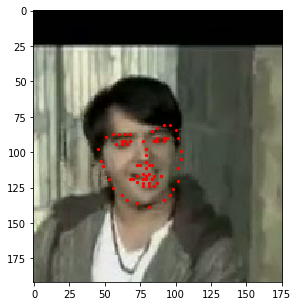

In [7]:
# Display a few different types of images by changing the index n

# select an image by index in our data frame
n = 0
image_name = key_pts_frame.iloc[n, 0]
key_pts = key_pts_frame.iloc[n, 1:].as_matrix()
key_pts = key_pts.astype('float').reshape(-1, 2)

plt.figure(figsize=(5, 5))
show_keypoints(mpimg.imread(os.path.join('/data/training/', image_name)), key_pts)
plt.show()

## Dataset类与转换

为了准备训练我们的数据，我们要使用PyTorch的Dataset类。这段代码大部分都是[PyTorch 数据加载教程](http://pytorch.org/tutorials/beginner/data_loading_tutorial.html)中代码的修改版。

#### Dataset类

``torch.utils.data.Dataset``是一个表示数据集的抽象类。这个类可以让我们加载批量的图像/关键点数据，并统一地将转换应用于我们的数据，例如，为了训练神经网络，重新缩放和归一化化图像。


你的自定义数据集应继承``Dataset``并覆盖以下方法：

-  ``__len__`` ，从而使``len(dataset)``返回数据集的大小。

-  ``__getitem__`` ，用于支持索引，使``dataset[i]`` 可
     用于获取第i个图像/关键点数据样本。

接下来，让我们为人脸关键点数据集创建一个dataset类。我们要读取``__init__``中的CSV文件，但将图像的读取留给``__getitem__``。这就是高效存储，因为所有图像都不是一次性存储在内存中，而是根据需要读取。

我们的数据集示例将是一个字典``{'image': image, 'keypoints': key_pts}``。该数据集将采用可选参数``transform``，这样的话，任何所需的处理都可以应用于样本。在下一部分，我们要学习的是``transform``的有效性。

In [8]:
from torch.utils.data import Dataset, DataLoader

class FacialKeypointsDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.key_pts_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.key_pts_frame)

    def __getitem__(self, idx):
        image_name = os.path.join(self.root_dir,
                                self.key_pts_frame.iloc[idx, 0])
        
        image = mpimg.imread(image_name)
        
        # if image has an alpha color channel（透明度）, get rid of it
        #本数据集最大只有3，没有alpha color channel
        if(image.shape[2] == 4):
            image = image[:,:,0:3]
        
        key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
        key_pts = key_pts.astype('float').reshape(-1, 2)
        sample = {'image': image, 'keypoints': key_pts}

        if self.transform:
            sample = self.transform(sample)

        return sample

现在，我们已经定义了这个类，接下来，我们要做的是实例化该数据集并显示一些图像。

In [9]:
# Construct the dataset
face_dataset = FacialKeypointsDataset(csv_file='/data/training_frames_keypoints.csv',
                                      root_dir='/data/training/')

# print some stats about the dataset
print('Length of dataset: ', len(face_dataset))

Length of dataset:  3462


In [10]:
face_dataset.key_pts_frame[:5]

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,126,127,128,129,130,131,132,133,134,135
0,Luis_Fonsi_21.jpg,45.0,98.0,47.0,106.0,49.0,110.0,53.0,119.0,56.0,...,83.0,119.0,90.0,117.0,83.0,119.0,81.0,122.0,77.0,122.0
1,Lincoln_Chafee_52.jpg,41.0,83.0,43.0,91.0,45.0,100.0,47.0,108.0,51.0,...,85.0,122.0,94.0,120.0,85.0,122.0,83.0,122.0,79.0,122.0
2,Valerie_Harper_30.jpg,56.0,69.0,56.0,77.0,56.0,86.0,56.0,94.0,58.0,...,79.0,105.0,86.0,108.0,77.0,105.0,75.0,105.0,73.0,105.0
3,Angelo_Reyes_22.jpg,61.0,80.0,58.0,95.0,58.0,108.0,58.0,120.0,58.0,...,98.0,136.0,107.0,139.0,95.0,139.0,91.0,139.0,85.0,136.0
4,Kristen_Breitweiser_11.jpg,58.0,94.0,58.0,104.0,60.0,113.0,62.0,121.0,67.0,...,92.0,117.0,103.0,118.0,92.0,120.0,88.0,122.0,84.0,122.0


In [67]:
face_dataset.root_dir

'/data/training/'

In [68]:
face_dataset.transform

In [70]:
face_dataset[0].keys()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:31: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


dict_keys(['image', 'keypoints'])

In [75]:
face_dataset[0]['keypoints'].shape

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:31: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


(68, 2)

In [122]:
list(face_dataset[0]['image'].shape)[2]

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:31: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


3

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:32: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


0 (223, 222, 3) (68, 2)
1 (172, 158, 3) (68, 2)
2 (231, 191, 3) (68, 2)


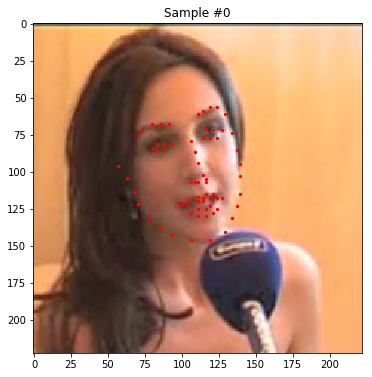

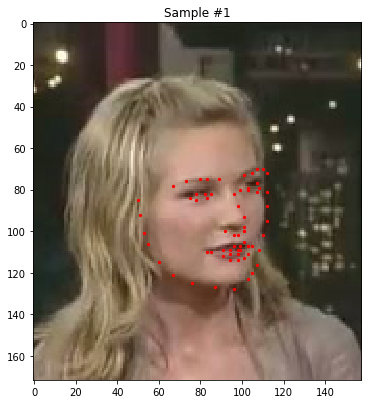

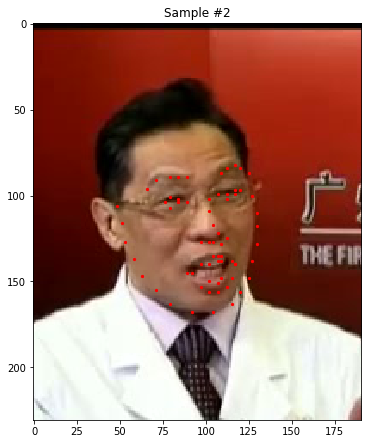

In [11]:
# Display a few of the images from the dataset
num_to_display = 3

for i in range(num_to_display):
    
    # define the size of images
    fig = plt.figure(figsize=(20,10))
    
    # randomly select a sample
    rand_i = np.random.randint(0, len(face_dataset))
    sample = face_dataset[rand_i]

    # print the shape of the image and keypoints
    print(i, sample['image'].shape, sample['keypoints'].shape)

    ax = plt.subplot(1, num_to_display, i + 1)
    ax.set_title('Sample #{}'.format(i))
    
    # Using the same display function, defined earlier
    show_keypoints(sample['image'], sample['keypoints'])


## 转换

现在，上面的图像尺寸不同，但是，神经网络通常期望的是标准化的图像。因此，我们需要固定的尺寸、颜色范围和坐标的标准化范围。对于PyTorch来说，还需要把numpy列表和数组转换为Tensors。

因此，我们需要编写一些预处理代码。
下面，创建四个转换：

-  ``Normalize``: 将彩色图像转换为范围为[0,1]的灰度值，并将关键点标准化为约[-1,1]的范围
-  ``Rescale``: 将图像重新缩放到所需尺寸。
-  ``RandomCrop``: 随机裁剪图像。
-  ``ToTensor``: 将numpy图像转换为torch图像。


我们将它们编写为可调用类而不是简单函数，这样，每次调用时都不需要传递转换的参数。 为此，我们只需要实现 ``__call__`` 方法就可以了。如果我们需要传入参数，还需要实现``__init__``方法。 我们可以使用类似下面的转换：

请注意以下这些转换通常是如何应用于图像及其关键点。

In [12]:
import torch
from torchvision import transforms, utils
# tranforms

class Normalize(object):
    """Convert a color image to grayscale and normalize the color range to [0,1]."""        
    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']
        
        image_copy = np.copy(image)
        key_pts_copy = np.copy(key_pts)

        # convert image to grayscale 把channel为3的图片转成了channel为1
        image_copy = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        
        # scale color range from [0, 255] to [0, 1]
        image_copy=  image_copy/255.0
        
        # scale keypoints to be centered around 0 with a range of [-1, 1]
        # mean = 100, sqrt = 50, so, pts should be (pts - 100)/50
        key_pts_copy = (key_pts_copy - 100)/50.0

        return {'image': image_copy, 'keypoints': key_pts_copy}


class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = cv2.resize(image, (new_w, new_h))
        
        # scale the pts, too
        key_pts = key_pts * [new_w / w, new_h / h]

        return {'image': img, 'keypoints': key_pts}


class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        key_pts = key_pts - [left, top]

        return {'image': image, 'keypoints': key_pts}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""
    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']
         
        # if image has no grayscale color channel, add one
        if(len(image.shape) == 2):
            # add that third color dim
            image = image.reshape(image.shape[0], image.shape[1], 1)
            
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        
        return {'image': torch.from_numpy(image),
                'keypoints': torch.from_numpy(key_pts)}

## 测试转换

接下来，需要对这些转换进行测试，确保它们按预期运行。查看每个转换时，请注意，在这里，**顺序非常重要**。例如，你不能用一个小于原始图像的值来裁剪图像，而且原始图像的尺寸会有所不同。但是，如果首先选择重新缩放原始图像，则可以将其裁剪为小于重新缩放尺寸的任何尺寸。

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:32: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


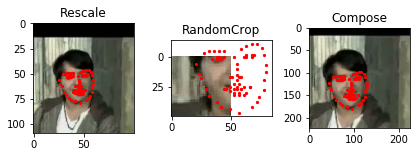

In [13]:
# test out some of these transforms
rescale = Rescale(100)
crop = RandomCrop(50)
composed = transforms.Compose([Rescale(250),
                               RandomCrop(224)])

# apply the transforms to a sample image
test_num = 0
sample = face_dataset[test_num]

fig = plt.figure()
for i, tx in enumerate([rescale, crop, composed]):
    transformed_sample = tx(sample)

    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tx).__name__)
    show_keypoints(transformed_sample['image'], transformed_sample['keypoints'])

plt.show()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:32: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


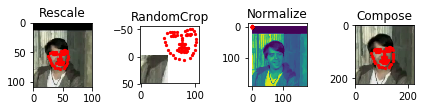

In [14]:
# test out some of these transforms
rescale = Rescale(100)
crop = RandomCrop(50)
normalize = Normalize()

composed = transforms.Compose([Rescale(250),
                               RandomCrop(224)])

# apply the transforms to a sample image
test_num = 0
sample = face_dataset[test_num]

fig = plt.figure()
for i, tx in enumerate([ rescale,crop,normalize, composed]):
    transformed_sample = tx(sample)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title(type(tx).__name__)
    show_keypoints(transformed_sample['image'], transformed_sample['keypoints'])

plt.show()

## 创建转换后的数据集

下面，我们需要使用转换获取相同形状的灰度图像。通过输出结果数据的形状来验证转换的工作原理（输出的几个示例应该显示出一致的张量大小）。

In [15]:
# define the data tranform
# order matters! i.e. rescaling should come before a smaller crop
data_transform = transforms.Compose([Rescale(250),
                                     RandomCrop(224),
                                     Normalize(),
                                     ToTensor()])

# create the transformed dataset
transformed_dataset = FacialKeypointsDataset(csv_file='/data/training_frames_keypoints.csv',
                                             root_dir='/data/training/',
                                             transform=data_transform)

In [16]:
# print some stats about the transformed data
print('Number of images: ', len(transformed_dataset))

# make sure the sample tensors are the expected size
for i in range(5):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

Number of images:  3462
0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])
4 torch.Size([1, 224, 224]) torch.Size([68, 2])


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:32: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


## 数据迭代与批处理

现在，我们使用``for``循环迭代这些数据，但是我们错过了很多PyTorch的数据集功能，特别是下列这些功能：

-  批量处理数据
-  置乱数据
-  使用``multiprocessing``工作程序并行加载数据。

而``torch.utils.data.DataLoader``是一个提供所有这些功能的迭代器。在*下一个*notebook中，需要批量加载数据来训练神经网络时，我们就会看到这个它的这个作用！

---



## 准备训练你的神经网络吧！

到目前为止，你已经了解了如何加载与转换数据，也为构建一个用于训练这些数据的神经网络做好了准备。

在下一个notebook中，你的任务是创建一个用于人脸关键点检测的CNN。